In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle

In [2]:
data = pd.read_csv('./Torcs_Sample_Data.csv')
data

,angle,curLapTime,damage,distFromStart,distRaced,fuel,SensorGear,lastLapTime,opponent1,opponent2,...,sFocus3,sFocus4,sFocus5,trackName,accel,brake,clutch,gear,steer,focus
0,0.009693,-0.982,0.0,2032.560,0.00,94.0,0.0,0.000,19.2202,38.0467,...,-1.0,-1.0,-1.0,CGSpeedwayNumber1,1.0,0.000000,0.64,1,0.318789,360
1,0.009693,-0.962,0.0,2032.560,0.00,94.0,0.0,0.000,19.2202,38.0467,...,-1.0,-1.0,-1.0,CGSpeedwayNumber1,1.0,0.000000,0.64,1,0.318789,360
2,0.009693,-0.942,0.0,2032.560,0.00,94.0,0.0,0.000,19.2202,38.0467,...,-1.0,-1.0,-1.0,CGSpeedwayNumber1,1.0,0.000000,0.64,1,0.318789,360
3,0.009693,-0.922,0.0,2032.560,0.00,94.0,0.0,0.000,19.2202,38.0467,...,-1.0,-1.0,-1.0,CGSpeedwayNumber1,1.0,0.000000,0.64,1,0.318789,360
4,0.009693,-0.902,0.0,2032.560,0.00,94.0,0.0,0.000,19.2202,38.0467,...,-1.0,-1.0,-1.0,CGSpeedwayNumber1,1.0,0.000000,0.64,1,0.318789,360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.143931,17.868,0.0,950.215,5090.33,94.0,3.0,41.716,200.0000,62.9114,...,-1.0,-1.0,-1.0,CGSpeedwayNumber1,0.0,0.000000,0.00,3,0.083078,360
4996,-0.129494,17.890,0.0,951.111,5091.23,94.0,3.0,41.716,200.0000,62.3446,...,-1.0,-1.0,-1.0,CGSpeedwayNumber1,0.0,0.719455,0.00,3,0.083889,360
4997,-0.119633,17.912,0.0,952.005,5092.12,94.0,3.0,41.716,200.0000,61.7759,...,-1.0,-1.0,-1.0,CGSpeedwayNumber1,0.0,0.884142,0.00,3,0.084303,360
4998,-0.112509,17.934,0.0,952.896,5093.01,94.0,3.0,41.716,200.0000,61.2044,...,-1.0,-1.0,-1.0,CGSpeedwayNumber1,0.0,0.000000,0.00,3,0.084459,360


In [20]:
train_indices = np.random.choice(np.arange(0, len(data)), 4000, replace=False)
val_indices = list(set(np.arange(0, len(data))) - set(train_indices))

In [21]:
col_to_delete = ['distFromStart', 'fuel', 'SensorGear', 'curLapTime', 'gear', 'damage', 'trackName', 'racePos']

In [22]:
for col in col_to_delete:
    del data[col]

In [23]:
training_data = data.loc[train_indices].reset_index(drop=True)
val_data = data.loc[val_indices].reset_index(drop=True)
training_data.columns

Index(['angle', 'distRaced', 'lastLapTime', 'opponent1', 'opponent2',
       'opponent3', 'opponent4', 'opponent5', 'opponent6', 'opponent7',
       'opponent8', 'opponent9', 'opponent10', 'opponent11', 'opponent12',
       'opponent13', 'opponent14', 'opponent15', 'opponent16', 'opponent17',
       'opponent18', 'opponent19', 'opponent20', 'opponent21', 'opponent22',
       'opponent23', 'opponent24', 'opponent25', 'opponent26', 'opponent27',
       'opponent28', 'opponent29', 'opponent30', 'opponent31', 'opponent32',
       'opponent33', 'opponent34', 'opponent35', 'opponent36', 'rpm', 'speedX',
       'speedY', 'speedZ', 'track1', 'track2', 'track3', 'track4', 'track5',
       'track6', 'track7', 'track8', 'track9', 'track10', 'track11', 'track12',
       'track13', 'track14', 'track15', 'track16', 'track17', 'track18',
       'track19', 'trackPos', 'wheelSpinVel1', 'wheelSpinVel2',
       'wheelSpinVel3', 'wheelSpinVel4', 'z', 'sFocus1', 'sFocus2', 'sFocus3',
       'sFocus4', 'sFo

In [24]:
x_train_columns = [
    "angle",
    # "distRaced",
    # "lastLapTime",
    # "opponent1",
    # "opponent2",
    # "opponent3",
    # "opponent4",
    # "opponent5",
    # "opponent6",
    # "opponent7",
    # "opponent8",
    # "opponent9",
    # "opponent10",
    # "opponent11",
    # "opponent12",
    # "opponent13",
    # "opponent14",
    # "opponent15",
    # "opponent16",
    # "opponent17",
    # "opponent18",
    # "opponent19",
    # "opponent20",
    # "opponent21",
    # "opponent22",
    # "opponent23",
    # "opponent24",
    # "opponent25",
    # "opponent26",
    # "opponent27",
    # "opponent28",
    # "opponent29",
    # "opponent30",
    # "opponent31",
    # "opponent32",
    # "opponent33",
    # "opponent34",
    # "opponent35",
    # "opponent36",
    # "rpm",
    "speedX",
    "speedY",
    # "speedZ",
    # "track1",
    # "track2",
    # "track3",
    # "track4",
    # "track5",
    # "track6",
    # "track7",
    # "track8",
    # "track9",
    # "track10",
    # "track11",
    # "track12",
    # "track13",
    # "track14",
    # "track15",
    # "track16",
    # "track17",
    # "track18",
    # "track19",
    "trackPos",
    # "wheelSpinVel1",
    # "wheelSpinVel2",
    # "wheelSpinVel3",
    # "wheelSpinVel4",
    # "z",
]

In [25]:
x_train = training_data[x_train_columns]
y_train = training_data[['accel', 'steer', 'brake']]
x_val = val_data[x_train_columns]
y_val = val_data[['accel', 'steer', 'brake']]

In [26]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val.values, dtype=torch.float32).to(device)

In [28]:
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [29]:
class Model(nn.Module):
    def __init__(self, input_size, output_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 8)
        self.fc6 = nn.Linear(8, output_size)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x
    
model = Model(x_train.shape[1], y_train.shape[1]).to(device)
print(x_train.shape[1], y_train.shape[1])
    

4 3


In [30]:
x_train.shape[1]

4

In [31]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 250
batch_size = 256

train_loss = []
val_loss = []
val_r2 = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_loss.append(epoch_loss)

    model.eval()
    with torch.no_grad():
        test_outputs = model(x_val)
        test_loss = criterion(test_outputs, y_val)
        val_loss.append(test_loss.item())
        val_r2.append(r2_score(y_val.cpu().numpy(), test_outputs.cpu().numpy()))
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss}, Val Loss: {test_loss.item()}, Val R2: {val_r2[-1]}')

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/250, Train Loss: 0.3424886052425091, Val Loss: 0.29762232303619385, Val R2: -3.1451440065103244
Epoch 2/250, Train Loss: 0.2644904530965365, Val Loss: 0.20006054639816284, Val R2: -1.5053949221418428
Epoch 3/250, Train Loss: 0.1662515516464527, Val Loss: 0.1369686871767044, Val R2: -1.7972622265207072
Epoch 4/250, Train Loss: 0.12458358246546525, Val Loss: 0.10452490299940109, Val R2: -0.9736836498918802
Epoch 5/250, Train Loss: 0.09672638028860092, Val Loss: 0.081695057451725, Val R2: -0.7311829639223699
Epoch 6/250, Train Loss: 0.07519879707923302, Val Loss: 0.06395203620195389, Val R2: -0.28927251799195436
Epoch 7/250, Train Loss: 0.06195931595105391, Val Loss: 0.056266337633132935, Val R2: -0.10352194783780577
Epoch 8/250, Train Loss: 0.056198325294714704, Val Loss: 0.0520499013364315, Val R2: 0.012923701112504182
Epoch 9/250, Train Loss: 0.053475141811829344, Val Loss: 0.0487198643386364, Val R2: 0.10863230503511427
Epoch 10/250, Train Loss: 0.050310604847394504, Val Loss:

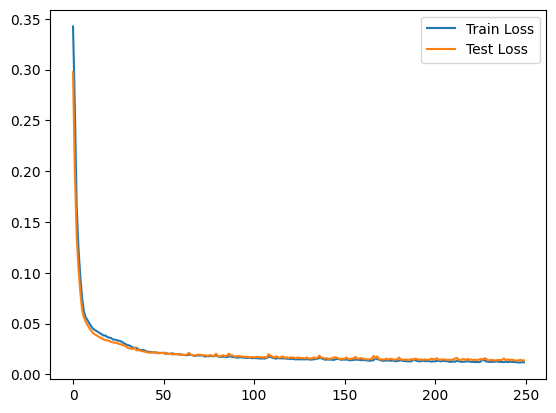

In [32]:
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Test Loss')
plt.legend()
plt.show()

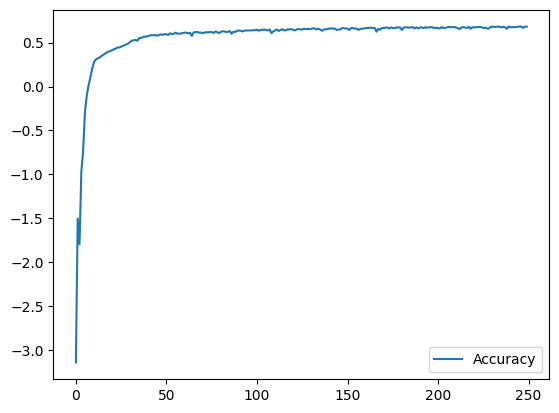

In [33]:
plt.plot(val_r2, label='Accuracy')
plt.legend()
plt.show()

In [34]:
#save model

torch.save(model.state_dict(), 'model.pth')
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

#load model
model = Model(x_train.shape[1], y_train.shape[1]).to(device)
model.load_state_dict(torch.load('model.pth'))  


<All keys matched successfully>